In [289]:
import json
import os
import re
import fnmatch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import sys
import tqdm
import scipy

import sklearn.manifold as sm
import sklearn.decomposition as sd
import sklearn.model_selection as ms
import statsmodels.api as sm
import sklearn.preprocessing as spr

import sklearn.metrics as sx
import sklearn.calibration as sc

%matplotlib inline
sns.set(style='whitegrid')

## General Idea

- Build simple logistic regression 

- See where it gets us

- Get valuable features

## Disclaimer

- Logistic regression works without any magic needed, avg accuracy score: `0.9`, roc-auc: `0.96+`

- Features interpretation

| Feature        | Pos/Neg effect in commute prob          | Makes sense?  |
| ------------- |:-------------| :-----|
|distance| Neg | Yes - long distance commutes are unlike
| max_speed | Neg | Yes - fast commutes are unlike
| nan_fraction | Pos | Yes (if nan fraction means you stop), in commute you tend to stay still more 
| slow_speed_fraction | Neg | Yes, the less slow speed you have the more likely that you train
| average_cadence | Neg | Yes
| velocitydiff_std_1m | Pos | Yes, the more volatile your speed, the more likely you're commuting in the city 
| velocitydiff_mean_5m | Neg | ?, hard to interpret the feature, mb something like - you ride as fast as you can, and its hard to keep the pace for 5m

## Unpickling the DF from the notebook: strava_files_dataprep

In [248]:
activity_df = pd.read_pickle('activity_df', compression="bz2")
stream_df = pd.read_pickle("stream_features", compression="bz2")
df = activity_df.merge(stream_df, left_index=True, right_index=True, how='left')

In [249]:
df.columns

Index(['average_cadence', 'average_heartrate', 'average_speed', 'average_temp',
       'average_watts', 'commute', 'device_watts', 'distance', 'elapsed_time',
       'has_heartrate', 'kilojoules', 'latlng', 'manual', 'max_speed',
       'moving_time', 'premium', 'acf0_10m', 'acf0_1m', 'acf0_5m',
       'nan_fraction', 'slow_speed_fraction', 'velocitydiff_mean_10m',
       'velocitydiff_mean_1m', 'velocitydiff_mean_5m', 'velocitydiff_std_10m',
       'velocitydiff_std_1m', 'velocitydiff_std_5m'],
      dtype='object')

In [250]:
training_cols =  ['average_speed', 'distance', 'has_heartrate', 'max_speed']+\
                 ['nan_fraction', 'slow_speed_fraction', 'average_heartrate', 'average_cadence']+\
                 ['velocitydiff_mean_1m', 'velocitydiff_std_1m', 'velocitydiff_mean_5m', 'velocitydiff_std_5m'] +\
                 ['acf0_1m', 'acf0_5m', 'acf0_10m']

In [251]:
dfn = df[training_cols].copy().apply(pd.to_numeric, errors='coerce').fillna(0)

# using the same heuristics for labeling
# 1. what lableled as commute is commute
# 2. power meter and no commute - is training

commute = (df['commute'] == 1).astype(int)
training = ( df['device_watts'] & ~df['commute']).astype(int)

target = pd.Series(index=df.index)
target.loc[commute == 1] = int(1)
target.loc[training == 1] = int(0)

exog = dfn[target.notnull()].copy()
scaler = spr.StandardScaler().fit(exog)

X = scaler.transform(exog)
y = target[target.notnull()].astype(int)

# Making simple logistic regression

In [277]:
X_train, X_test, y_train, y_test = ms.train_test_split(sm.add_constant(X, prepend=False), y)
lr = sm.Logit(y_train, X_train).fit_regularized(refit=False) 
lr.summary2()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2180179652467582
            Iterations: 97
            Function evaluations: 97
            Gradient evaluations: 97


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.682      
Dependent Variable: y                AIC:              593.1782   
Date:               2017-12-05 11:56 BIC:              675.7393   
No. Observations:   1287             Log-Likelihood:   -280.59    
Df Model:           15               LL-Null:          -882.96    
Df Residuals:       1271             LLR p-value:      1.5610e-247
Converged:          True             Scale:            1.0000     
No. Iterations:     97.0000                                       
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
x1        -0.1368     0.1769    -0.7735   0.4392   -0.4836    0.2099
x2        -2.1509     0.3157    -6.8133   0.0000   -2.7696   -1.5321
x3        -0.8677     0.6240    -1.3907   0.1643   -2.0907    0.3552
x4        -0.4799     0.1703    -2.8184   0.0048   -0.8137   -0.1462
x5         0.4390     0.1439     3.0500   0.0023    0.1569    0.7212
x6        -0.5235     0.1740    -3.0078   0.0026   -0.8646   -0.1824
x7         0.6237     0.6200     1.0058   0.3145   -0.5916    1.8389
x8        -2.2925     0.2242   -10.2245   0.0000   -2.7320   -1.8530
x9         0.2583     0.1857     1.3907   0.1643   -0.1057    0.6223
x10        0.8095     0.2494     3.2455   0.0012    0.3207    1.2984
x11       -0.3871     0.1862    -2.0795   0.0376   -0.7520   -0.0223
x12       -0.5238     0.2720    -1.9255   0.0542   -1.0569    0.0094
x13       -0.0015     0.2484    -0.0060   0.9952   -0.4882    0.4853
x14       -0.0513     0.3208    -0.1600   0.8729   -0.6801    0.5775
x15        0.3412     0.2677     1.2746   0.2025   -0.1835    0.8658
const     -0.1144     0.1655    -0.6914   0.4893   -0.4388    0.2100
==================================================================

"""

Important / Not important cols

In [287]:
conf_int = pd.DataFrame(lr.conf_int()).set_index(pd.Index(training_cols + ['const']))
not_important_mask = (conf_int[0] < 0) & (conf_int[1] > 0)
print("Not important cols, (95conf. interval crosses 0)")
conf_int[not_important_mask] 

Not important cols, (95conf. interval crosses 0)


,0,1
average_speed,-0.483597,0.209907
has_heartrate,-2.090687,0.355196
average_heartrate,-0.591613,1.838924
velocitydiff_mean_1m,-0.105720,0.622291
velocitydiff_std_5m,-1.056932,0.009382
acf0_1m,-0.488249,0.485285
acf0_5m,-0.680103,0.577452
acf0_10m,-0.183460,0.865827
const,-0.438836,0.209959


Important cols

In [286]:
conf_int[~not_important_mask] 

,0,1
distance,-2.769589,-1.532131
max_speed,-0.813677,-0.146179
nan_fraction,0.156902,0.721154
slow_speed_fraction,-0.864557,-0.182359
average_cadence,-2.731963,-1.853048
velocitydiff_std_1m,0.320665,1.298431
velocitydiff_mean_5m,-0.752026,-0.022257


## Making sure the classifier is calibrated 

(looks like it is ok)

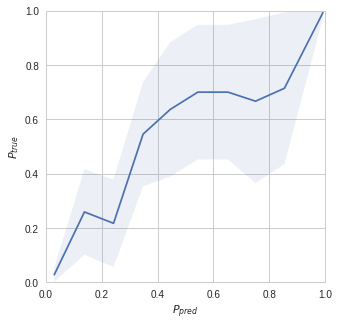

In [255]:
def wilson(p, n, z=1.96):
    return z * np.sqrt((p * (1 - p) + z * z / (4 * n)) / n) / (1 + z * z / n)

n_bins=10
T_test_pred = lr.predict(X_test)
p_true, p_pred = sc.calibration_curve(y_test, 
                                      T_test_pred, 
                                      n_bins=n_bins)

bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
binids = np.digitize(T_test_pred, bins) - 1
bin_total = np.bincount(binids, minlength=len(bins))
ci = wilson(p_true, bin_total[bin_total != 0])

fig, ax = pl.subplots(figsize=(5, 5))
ax.plot(p_pred, p_true)
ax.fill_between(p_pred, p_true-ci, p_true+ci, alpha=0.1)
ax.set_xlim(0, 1)
ax.set_xlabel("$P_{pred}$")
ax.set_ylim(0, 1)
ax.set_ylabel("$P_{true}$")
print()

## A bit of bootstraping to get aggregated performance overview

In [ ]:
n_splits = 4
n_repeats = 30
rkf = ms.RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
classifier_stats = []

for train_index, test_index in tqdm.tqdm_notebook(rkf.split(sm.add_constant(X,prepend=False)), total=n_splits*n_repeats):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    lr = sm.Logit(y_train, X_train).fit_regularized(refit=True)    
    pred = lr.predict(X_test)    
    classifier_stats.append({
        'roc_auc': sx.roc_auc_score(y_true=y_test, y_score=pred),
        'acc_score': sx.accuracy_score(y_true=y_test, y_pred=pred>0.5)
        }
    )

## The resiults are: med accuracy score: 90%, med roc_auc: 0.96+

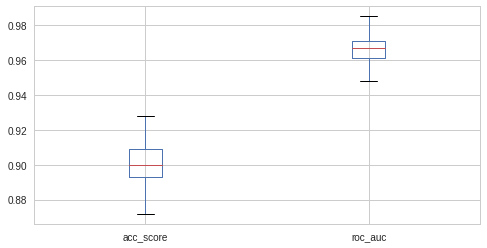

In [288]:
pd.DataFrame(classifier_stats).boxplot(figsize=(8,4))
print()